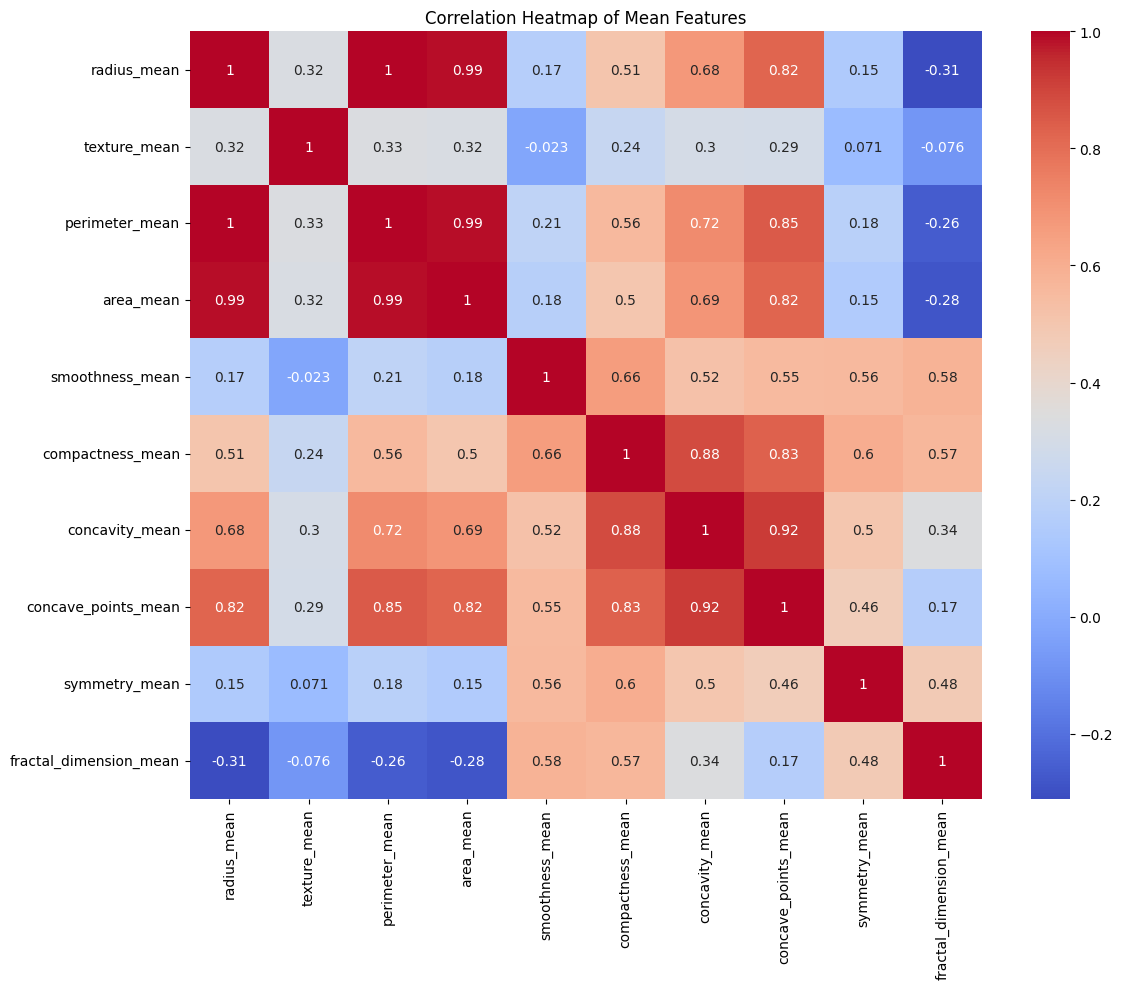

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
column_names = [
    'ID', 'Diagnosis', 
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

df = pd.read_csv('wdbc.data', header=None, names=column_names)

# Drop ID for analysis
df.drop('ID', axis=1, inplace=True)

# Convert Diagnosis to binary
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})

# Basic information
summary = df.describe()

# Visualization: correlation heatmap of mean features
mean_features = [col for col in df.columns if '_mean' in col]

plt.figure(figsize=(12, 10))
corr = df[mean_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Mean Features')
plt.tight_layout()
plt.show()


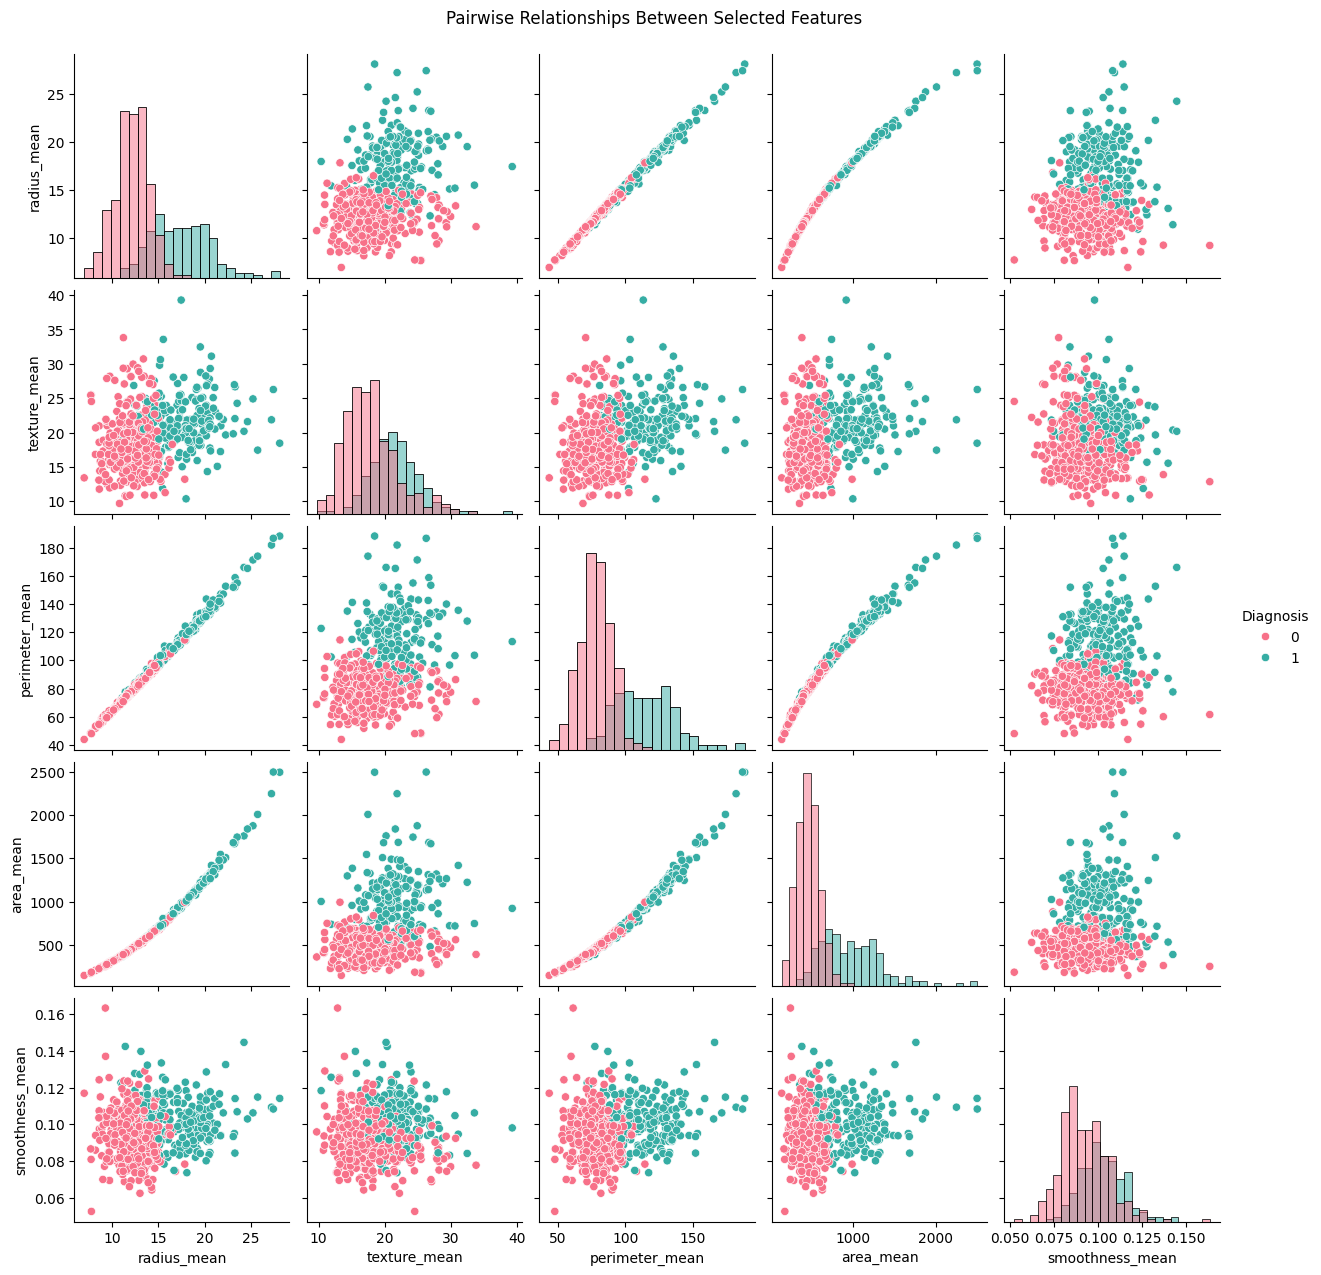

In [ ]:
import itertools
# Remove 'Diagnosis' column from pairplot, as it's categorical, and include it only as hue
features_only = [col for col in selected_features if col != 'Diagnosis']

# Recreate pairplot with numeric-only features and hue as Diagnosis
sns.pairplot(df[features_only + ['Diagnosis']], hue='Diagnosis', diag_kind='hist', palette='husl')
plt.suptitle('Pairwise Relationships Between Selected Features', y=1.02)
plt.show()


Key Insights:

radius_mean, area_mean, and perimeter_mean:
There is a strong positive correlation among these three features. This means that as the size of the tumor increases, both its perimeter and surface area also increase.

texture_mean and smoothness_mean:
These features display a more scattered distribution, potentially indicating a lower discriminative power compared to the others.

Class Separation (Diagnosis):
The classes (displayed with colors: malignant = 1, benign = 0) tend to cluster along the radius_mean and area_mean axes. This suggests that there are strong, distinguishing features that could be used for classification.

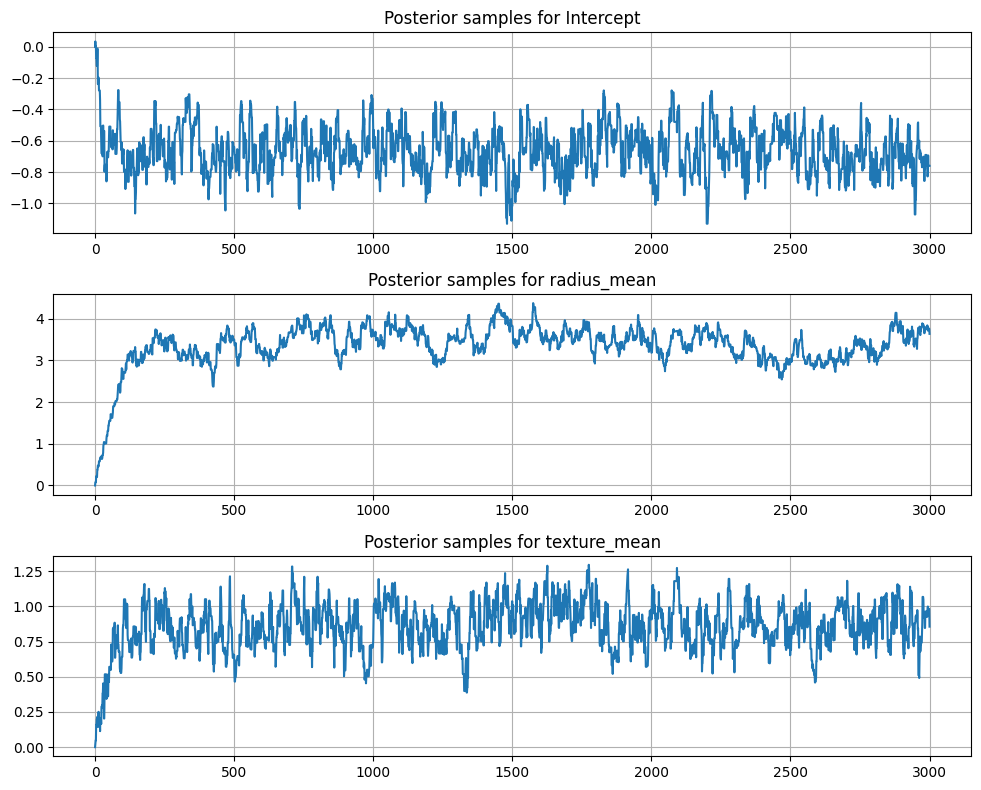

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example MCMC application: Logistic regression parameter estimation (Metropolis-Hastings)

# Prepare
X = df[['radius_mean', 'texture_mean']]
y = df['Diagnosis'].values

# Normalize
X = (X - X.mean()) / X.std()
X = np.c_[np.ones(X.shape[0]), X.values]  # Bias ekle
n_samples, n_features = X.shape

# Logical sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Log posterior (öncelik: Normal, likelihood: Bernoulli)
def log_posterior(beta):
    z = np.dot(X, beta)
    log_likelihood = np.sum(y * np.log(sigmoid(z)) + (1 - y) * np.log(1 - sigmoid(z)))
    log_prior = -0.5 * np.sum(beta**2)  # Gaussian prior
    return log_likelihood + log_prior

# Metropolis-Hastings algoritması
def metropolis_hastings(log_posterior, initial, steps=5000, proposal_std=0.1):
    beta_current = initial
    posterior_trace = [beta_current]
    
    for _ in range(steps):
        beta_proposal = beta_current + np.random.normal(0, proposal_std, size=n_features)
        log_ratio = log_posterior(beta_proposal) - log_posterior(beta_current)
        
        if np.log(np.random.rand()) < log_ratio:
            beta_current = beta_proposal
        posterior_trace.append(beta_current)
    
    return np.array(posterior_trace)

# Begin MCMC
# Initial beta coefficients
initial_beta = np.zeros(n_features)
trace = metropolis_hastings(log_posterior, initial_beta, steps=3000)

# Visualize the posterior samples
fig, axes = plt.subplots(n_features, 1, figsize=(10, 8))
param_names = ['Intercept', 'radius_mean', 'texture_mean']
for i in range(n_features):
    axes[i].plot(trace[:, i])
    axes[i].set_title(f'Posterior samples for {param_names[i]}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


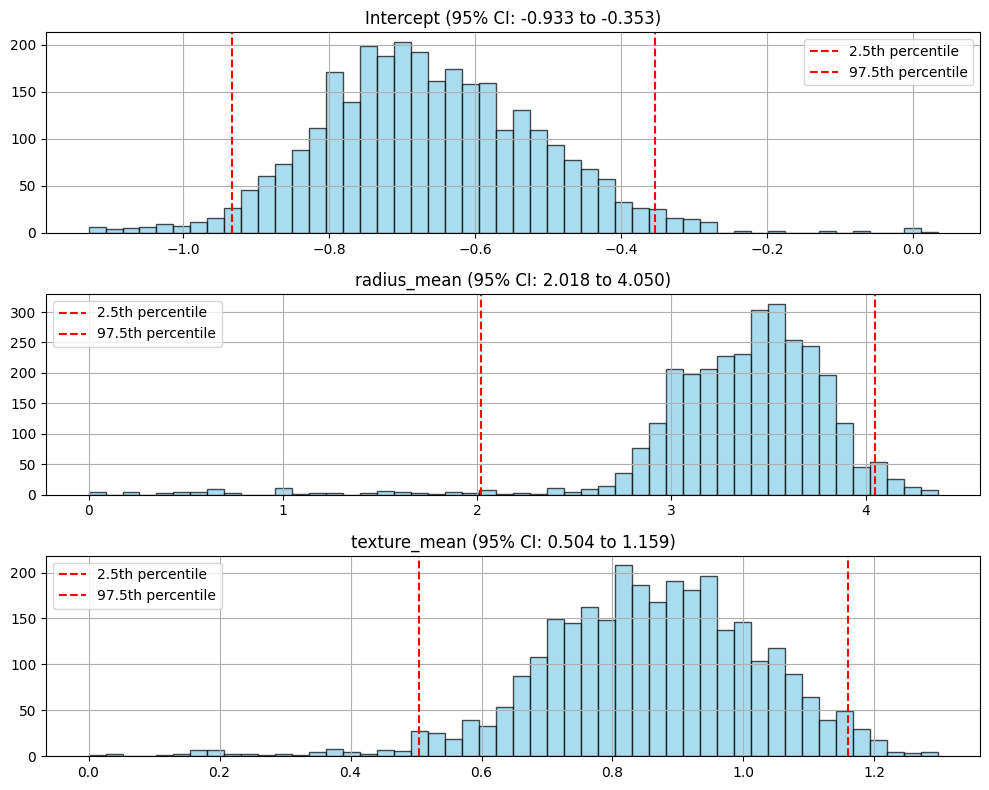

{'Intercept': (np.float64(-0.9334473518637576),
  np.float64(-0.35349954244630954)),
 'radius_mean': (np.float64(2.0178145183721674),
  np.float64(4.049896193346039)),
 'texture_mean': (np.float64(0.5042197019942531),
  np.float64(1.1589936151707716))}

In [ ]:


fig, axes = plt.subplots(n_features, 1, figsize=(10, 8))
credible_intervals = {}

for i in range(n_features):
    samples = trace[:, i]
    lower, upper = np.percentile(samples, [2.5, 97.5])
    credible_intervals[param_names[i]] = (lower, upper)

    axes[i].hist(samples, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].axvline(lower, color='red', linestyle='--', label='2.5th percentile')
    axes[i].axvline(upper, color='red', linestyle='--', label='97.5th percentile')
    axes[i].set_title(f"{param_names[i]} (95% CI: {lower:.3f} to {upper:.3f})")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

credible_intervals  # Display the interval values as output


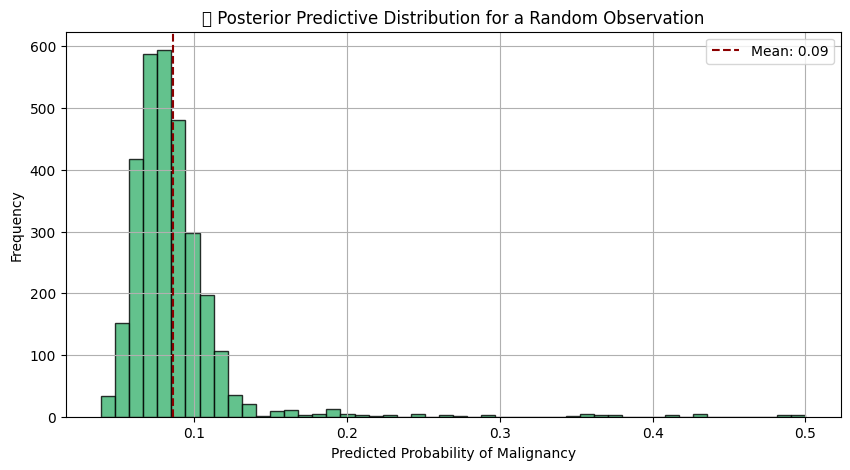

np.float64(0.08571953447169507)

In [ ]:


# Choose a random observation from the dataset
random_index = np.random.choice(len(X))
observation = X[random_index]

# Her örneklenmiş beta ile bu gözlem için tahmini hesaplayalım
posterior_probs = sigmoid(np.dot(trace, observation))

# visualize the posterior predictive distribution
plt.figure(figsize=(10, 5))
plt.hist(posterior_probs, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.8)
plt.axvline(np.mean(posterior_probs), color='darkred', linestyle='--', label=f"Mean: {np.mean(posterior_probs):.2f}")
plt.title("📈 Posterior Predictive Distribution for a Random Observation")
plt.xlabel("Predicted Probability of Malignancy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Average probability of malignancy for the selected observation
np.mean(posterior_probs)


In [18]:
# Define classification threshold (e.g., 50%)
threshold = 0.5

# Decision: Is the average probability above the threshold?
predicted_class = int(np.mean(posterior_probs) > threshold)

# Get the true class for comparison
true_class = y[random_index]

# Print the result
{
    "Selected sample index": random_index,
    "True class (1=Malignant, 0=Benign)": int(true_class),
    "Predicted average probability": round(np.mean(posterior_probs), 3),
    "Model decision (threshold = 0.5)": predicted_class,
    "Is the decision correct?": predicted_class == int(true_class)
}


{'Selected sample index': 403,
 'True class (1=Malignant, 0=Benign)': 0,
 'Predicted average probability': np.float64(0.086),
 'Model decision (threshold = 0.5)': 0,
 'Is the decision correct?': True}